# Observe reconstruction fidelity

In [27]:
import VAE_tybalt
from VAE_tybalt import VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [4]:
model.load_state_dict(torch.load('vae_weights.pth'))

<All keys matched successfully>

Load data

In [5]:
tcga_tybalt_file_location = 'data/rnaseq_df_test.csv'
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1,  inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [7]:
rnaseq_df.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.000000,0.676411,0.538535,0.829060,0.371617,0.076709,0.493035,0.495491,0.000000,0.000000,...,0.641401,0.258891,0.520563,0.400908,0.437579,0.560402,0.483713,0.054940,0.333915,0.313550
1,0.000000,0.601335,0.791538,0.580519,0.711329,0.771928,0.557838,0.656916,0.000000,0.000000,...,0.608653,0.157189,0.526314,0.651298,0.422983,0.648942,0.718139,0.030541,0.219439,0.447640
2,0.000000,0.801651,0.515508,0.526579,0.119657,0.212524,0.086728,0.253842,0.000000,0.000000,...,0.278018,0.160775,0.496794,0.384108,0.434125,0.476615,0.634136,0.000000,0.433654,0.308404
3,0.767083,0.132404,0.000000,0.461636,0.000000,0.000000,0.000000,0.046623,0.774512,0.736268,...,0.359250,0.657670,0.340666,0.708832,0.358783,0.328927,0.500310,0.000000,0.224678,0.514864
4,0.022867,0.731514,0.140167,0.749021,0.750316,0.031328,0.000000,0.716501,0.000000,0.000000,...,0.851758,0.450602,0.528139,0.605051,0.601097,0.446412,0.684836,0.074063,0.170475,0.413623


In [8]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = model.forward(torch.tensor(rnaseq_df.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns)

In [9]:
input_rnaseq_reconstruct.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.011764,0.810536,0.588156,0.750473,0.448281,0.173756,0.496338,0.611900,0.007752,0.007776,...,0.668192,0.445925,0.496130,0.436326,0.496851,0.457882,0.587703,0.101570,0.257774,0.393536
1,0.111375,0.407019,0.784879,0.652188,0.696676,0.763648,0.645378,0.701999,0.082032,0.068420,...,0.367172,0.170228,0.572308,0.506666,0.341770,0.612953,0.741944,0.021175,0.315472,0.360109
2,0.020280,0.654281,0.603229,0.429021,0.154669,0.442871,0.357174,0.292501,0.016123,0.015960,...,0.332102,0.321100,0.441275,0.455085,0.441005,0.525873,0.642416,0.060936,0.381370,0.538281
3,0.381872,0.481465,0.245689,0.431390,0.028776,0.119562,0.211483,0.145022,0.389584,0.391865,...,0.454480,0.592611,0.379701,0.590104,0.515600,0.346181,0.483097,0.090717,0.395263,0.655291
4,0.365243,0.445646,0.287868,0.681262,0.573269,0.202771,0.165523,0.640270,0.371278,0.346551,...,0.593177,0.407272,0.473059,0.555878,0.565744,0.519341,0.720589,0.127583,0.351250,0.480312


In [10]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.005413,0.240228
GSTT1,0.017423,0.231286
GSTM1,0.001714,0.221548
DDX3Y,-0.010332,0.216252
EIF1AY,-0.009381,0.213953


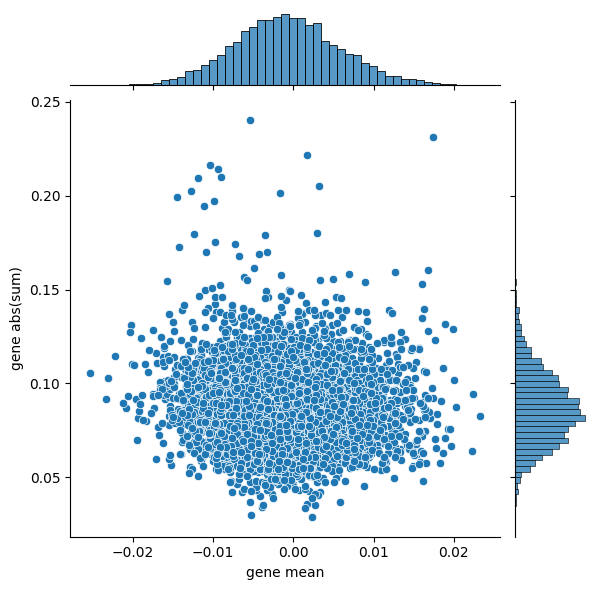

In [11]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

Compute reconstruction losses

In [62]:
BCE_loss = []
KLD_loss = []
MSE_loss = []
# print row vectors next to each other in a loop
for i in range(len(rnaseq_df)):
    x = torch.Tensor(rnaseq_df.iloc[i].values)
    y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
    bce_loss = F.binary_cross_entropy(x, y)
    mse_loss = F.mse_loss(x,y)
    
    #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
    #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))
    
    #kld_loss = torch.sum(kl_divergence(x, prior).item())
    BCE_loss.append(bce_loss)
    MSE_loss.append(mse_loss)
    

Permutation and adding noise

In [63]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled


In [64]:
rnaseq_df.shape[1]

5000

In [65]:
#1 percent of data shuffeled
rnaseq_df_1 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [66]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1 = model.forward(torch.tensor(rnaseq_df_1.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3 = model.forward(torch.tensor(rnaseq_df_3.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5 = model.forward(torch.tensor(rnaseq_df_5.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8 = model.forward(torch.tensor(rnaseq_df_8.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10 = model.forward(torch.tensor(rnaseq_df_10.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20 = model.forward(torch.tensor(rnaseq_df_20.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20.detach().numpy(), columns=rnaseq_df.columns)

In [67]:
#compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y, reduction='sum')
        mse_loss = F.mse_loss(x,y, reduction='sum')

        #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        #kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss.numpy().item())
        MSE_loss.append(mse_loss.numpy().item())
        
    return BCE_loss, MSE_loss

In [68]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20)[0]))

6975.6319288323075
7004.211454840053
6998.762962793529
7057.8582813853745
7273.932372113259
8775.393259081284


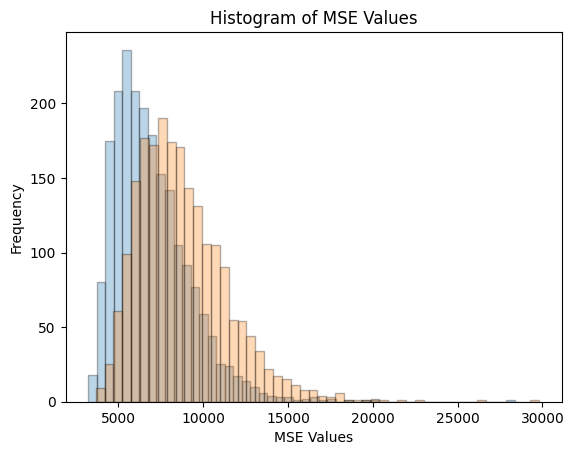

In [69]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20)[0], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

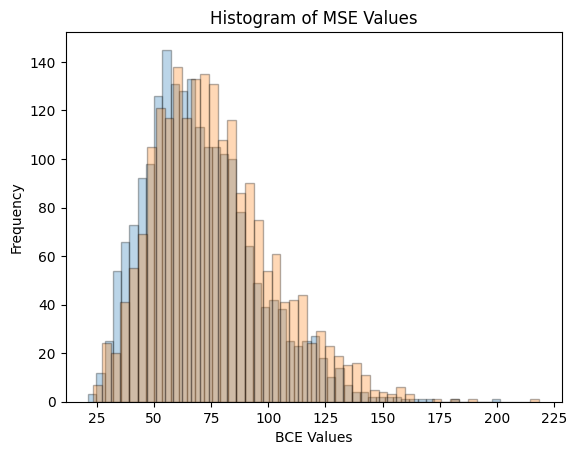

In [70]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10)[1], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('BCE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

In [71]:
# Each row is shuffled identically
import pandas as pd
import numpy as np

def shuffle_same_subset_rows(df, subset_size):
    """
    Shuffles the same random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    subset_cols = np.random.choice(num_cols, subset_size, replace=False)
    for i in range(len(df_shuffled)):
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled



In [72]:
#1 percent of data shuffeled
rnaseq_df_1 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [73]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1 = model.forward(torch.tensor(rnaseq_df_1.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3 = model.forward(torch.tensor(rnaseq_df_3.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5 = model.forward(torch.tensor(rnaseq_df_5.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8 = model.forward(torch.tensor(rnaseq_df_8.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10 = model.forward(torch.tensor(rnaseq_df_10.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20 = model.forward(torch.tensor(rnaseq_df_20.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20.detach().numpy(), columns=rnaseq_df.columns)

In [74]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20)[0]))

6975.6319288323075
6986.947051593496
7001.767381482097
7064.5779687359955
7235.992598174407
8712.409901722895


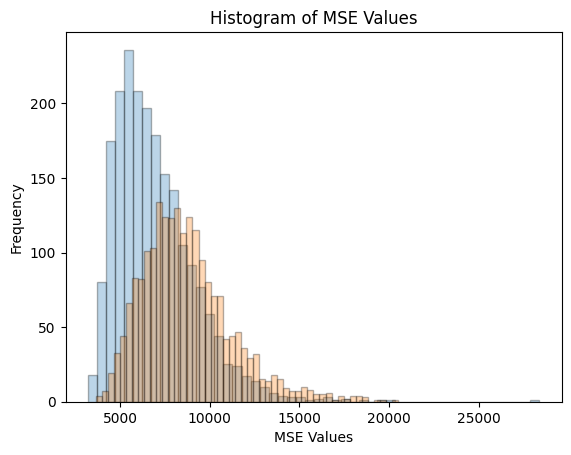

In [75]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20)[0], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

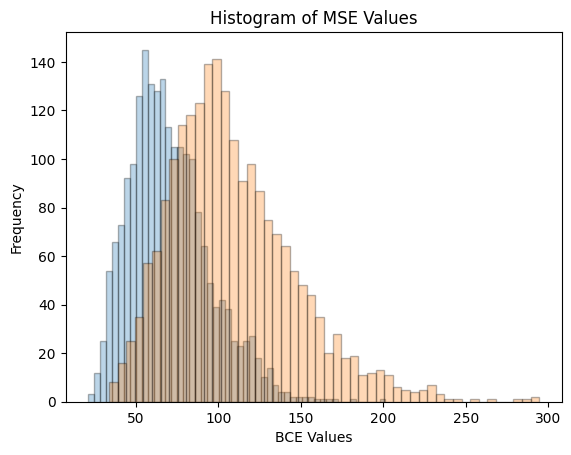

In [78]:
# Sample list of Mean Squared Error (MSE) values


# Create a histogram plot for MSE values
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
plt.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20)[1], bins=50, edgecolor='black', alpha=0.3)
plt.xlabel('BCE Values')
plt.ylabel('Frequency')
plt.title('Histogram of MSE Values')

# Show the plot
plt.show()

In [77]:
tcga_file_location = 'data/rescaled_5000_tcga_df_sort.tsv.gz'
target_file_location = 'data/rescaled_5000_target_df_sort.tsv.gz'
gtex_file_location = 'data/rescaled_5000_gtex_df_sort.tsv.gz'

tcga_df = pd.read_table(tcga_file_location)
target_df = pd.read_table(target_file_location)
gtex_df = pd.read_table(gtex_file_location)

tcga_df.drop(columns=tcga_df.columns[0], axis=1,  inplace=True)
target_df.drop(columns=target_df.columns[0], axis=1,  inplace=True)
gtex_df.drop(columns=gtex_df.columns[0], axis=1,  inplace=True)

tcga_df = tcga_df.dropna()
target_df = target_df.dropna()
gtex_df = gtex_df.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'data/rescaled_5000_tcga_df_sort.tsv.gz'

In [30]:
# How well does the model reconstruct the input RNAseq data
input_tcga_reconstruct_tensor = model.forward(torch.tensor(tcga_df.values, dtype=torch.float32))[0]
input_target_reconstruct_tensor = model.forward(torch.tensor(target_df.values, dtype=torch.float32))[0]
input_gtex_reconstruct_tensor = model.forward(torch.tensor(gtex_df.values, dtype=torch.float32))[0]

input_tcga_reconstruct = pd.DataFrame(input_tcga_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)
input_target_reconstruct = pd.DataFrame(input_target_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)
input_gtex_reconstruct = pd.DataFrame(input_gtex_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)

In [31]:
reconstruction_fidelity_tcga = tcga_df - input_tcga_reconstruct
reconstruction_fidelity_target = target_df - input_target_reconstruct
reconstruction_fidelity_gtex = gtex_df - input_gtex_reconstruct

gene_mean_tcga = reconstruction_fidelity_tcga.mean(axis=0)
gene_mean_target = reconstruction_fidelity_target.mean(axis=0)
gene_mean_gtex = reconstruction_fidelity_gtex.mean(axis=0)

gene_abssum_tcga = reconstruction_fidelity_tcga.abs().sum(axis=0).divide(tcga_df.shape[0])
gene_abssum_target = reconstruction_fidelity_target.abs().sum(axis=0).divide(target_df.shape[0])
gene_abssum_gtex = reconstruction_fidelity_gtex.abs().sum(axis=0).divide(gtex_df.shape[0])

gene_summary_tcga = pd.DataFrame([gene_mean_tcga, gene_abssum_tcga], index=['gene mean', 'gene abs(sum)']).T
gene_summary_target = pd.DataFrame([gene_mean_target, gene_abssum_target], index=['gene mean', 'gene abs(sum)']).T
gene_summary_gtex = pd.DataFrame([gene_mean_gtex, gene_abssum_gtex], index=['gene mean', 'gene abs(sum)']).T

In [32]:
gene_summary_tcga.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
125704,-0.669962,0.670177
200373,-0.659565,0.659679
2762,-0.644884,0.645112
6335,-0.637946,0.638439
8821,-0.633234,0.633397


In [33]:
gene_summary_target.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
7552,0.588712,0.590006
7409,0.528928,0.537181
286097,0.529543,0.534122
114928,0.510642,0.512491
51166,0.472917,0.509442


In [34]:
gene_summary_gtex.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
1995,-0.585864,0.588569
284656,-0.578255,0.580297
57449,-0.560480,0.560831
784,-0.540976,0.541777
2905,-0.536077,0.538771


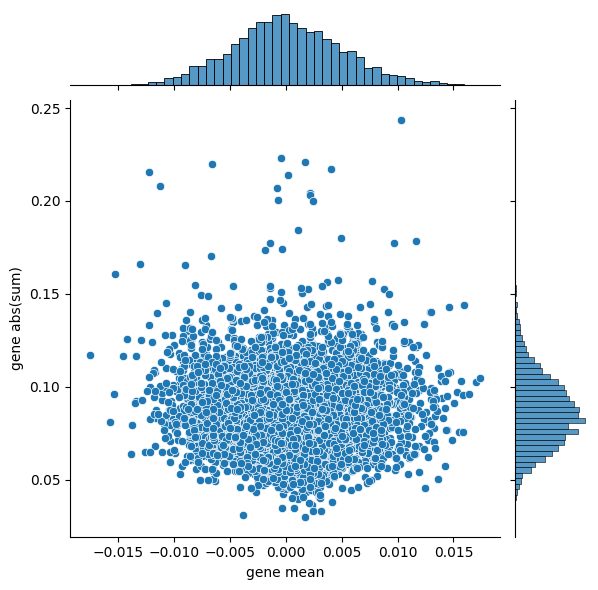

In [35]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

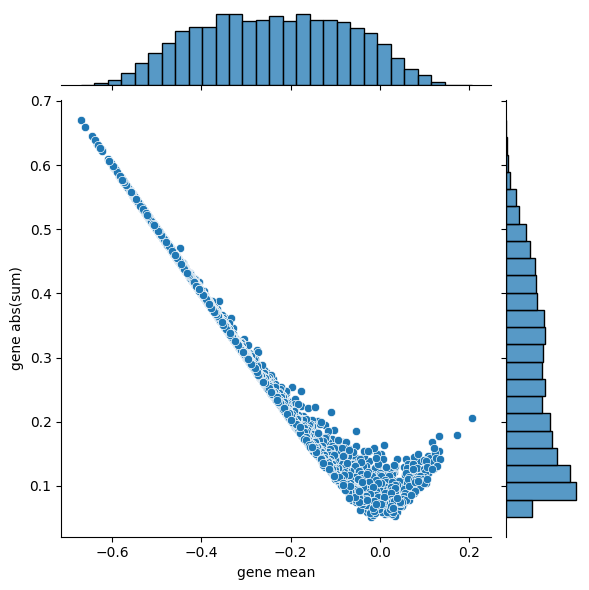

In [36]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_tcga)

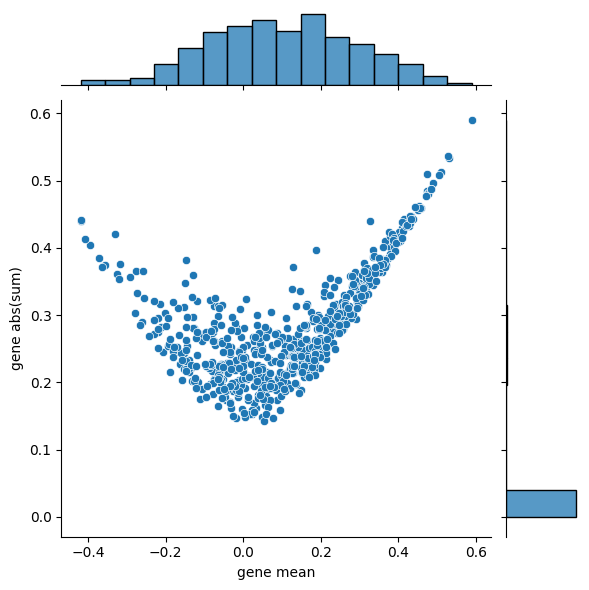

In [37]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_target)

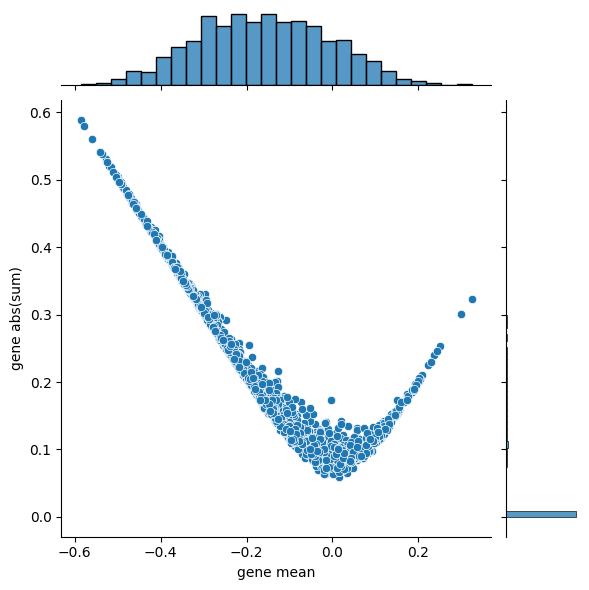

In [38]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_gtex)

Reconstruction after shuffling 

In [39]:
import random
cols = rnaseq_df_test.columns.tolist()
random.shuffle(cols)

NameError: name 'rnaseq_df_test' is not defined

In [ ]:
cols_all_index = list(range(len(cols)))
cols_all_index_100 = list(sample(cols_all_index,100))
cols_all_index_1000 = list(sample(cols_all_index,1000))
cols_all_index_5000 = list(sample(cols_all_index,5000))

In [ ]:
permute_elements_100 = [cols[i] for i in cols_all_index_100]
permute_elements_1000 = [cols[i] for i in cols_all_index_1000]
permute_elements_5000 = [cols[i] for i in cols_all_index_5000]

In [ ]:
random.shuffle(permute_elements_100)
random.shuffle(permute_elements_1000)
random.shuffle(permute_elements_5000)

In [ ]:
permuted_cols_100 = cols.copy()
permuted_cols_1000 = cols.copy()
permuted_cols_5000 = cols.copy()

In [ ]:
for i, index in enumerate(cols_all_index_100):
    permuted_cols_100[index] = permute_elements_100[i]

for i, index in enumerate(cols_all_index_1000):
    permuted_cols_1000[index] = permute_elements_1000[i]

for i, index in enumerate(cols_all_index_5000):
    permuted_cols_5000[index] = permute_elements_5000[i]

In [ ]:
rnaseq_df_shuffled_100 = pd.DataFrame(rnaseq_df_test[permuted_cols_100])
rnaseq_df_shuffled_1000 = pd.DataFrame(rnaseq_df_test[permuted_cols_1000])
rnaseq_df_shuffled_5000 = pd.DataFrame(rnaseq_df_test[permuted_cols_5000])

In [ ]:
validation_loader_shuffled_100 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_100), 
                                                         batch_size=100, shuffle=True)
validation_loader_shuffled_1000 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_1000), 
                                                         batch_size=100, shuffle=True)
validation_loader_shuffled_5000 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_5000), 
                                                         batch_size=100, shuffle=True)

In [1]:
import numpy as np

In [2]:
np.mean([1,2,3])

2.0